In [1]:
''' make sure to install these dependencies (python3 pip install ... ; or python3 -m pip install ...) '''
import pandas as pd
import numpy as np
import re
# import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from geopy.distance import geodesic
from matplotlib import pyplot as plt

In [2]:
airTraffic_df = pd.read_csv("data/air_traffic.csv")
avgFare_df = pd.read_csv("data/quarterly_avg_air_fare.csv")
carriers_df = pd.read_csv("data/carriers_routes.csv")
faresByCity_df = pd.read_csv("data/city_pair_fares.csv")

In [3]:
airTraffic_df.head()

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
0,2003,1,"43,032,450","4,905,830","47,938,280","785,160","57,667","842,827","36,211,422","12,885,980","49,097,402","56,191,300","17,968,572","74,159,872",64.44,71.71,66.20
1,2003,2,"41,166,780","4,245,366","45,412,146","690,351","51,259","741,610","34,148,439","10,715,468","44,863,907","50,088,434","15,587,880","65,676,314",68.18,68.74,68.31
2,2003,3,"49,992,700","5,008,613","55,001,313","797,194","58,926","856,120","41,774,564","12,567,068","54,341,633","57,592,901","17,753,174","75,346,075",72.53,70.79,72.12
3,2003,4,"47,033,260","4,345,444","51,378,704","766,260","55,005","821,265","39,465,980","10,370,592","49,836,572","54,639,679","15,528,761","70,168,440",72.23,66.78,71.02
4,2003,5,"49,152,352","4,610,834","53,763,186","789,397","55,265","844,662","41,001,934","11,575,026","52,576,960","55,349,897","15,629,821","70,979,718",74.08,74.06,74.07


In [4]:
carriers_df.head()
# carriers_df['UNIQUE_CARRIER']
# carriers_df['DEST_CITY_NAME']


,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,UNIQUE_CARRIER_ENTITY,REGION,CARRIER,...,DEST,DEST_CITY_NAME,DEST_COUNTRY,DEST_COUNTRY_NAME,DEST_WAC,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS
0,0.0,0.0,0.0,19.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,YWH,"Victoria, Canada",CA,Canada,906,2024,2,6,1,L
1,0.0,0.0,0.0,45.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,CXH,"Vancouver, Canada",CA,Canada,906,2024,2,4,1,L
2,0.0,0.0,0.0,47.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,FRD,"Friday Harbor, WA",US,United States,93,2024,2,5,1,L
3,0.0,0.0,0.0,53.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,FBS,"Friday Harbor, WA",US,United States,93,2024,2,5,1,L
4,0.0,0.0,0.0,60.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,ZNA,"Nanaimo, Canada",CA,Canada,906,2024,2,6,1,F


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
print(faresByCity_df.head())

   Year  quarter  citymarketid_1  citymarketid_2  \
0  2009        2           32467           34576   
1  2000        4           30397           33198   
2  2007        4           32575           34614   
3  2004        4           32337           31650   
4  2008        4           30194           30559   

                                 city1                     city2  nsmiles  \
0        Miami, FL (Metropolitan Area)             Rochester, NY     1204   
1      Atlanta, GA (Metropolitan Area)           Kansas City, MO      692   
2  Los Angeles, CA (Metropolitan Area)        Salt Lake City, UT      590   
3                     Indianapolis, IN  Minneapolis/St. Paul, MN      503   
4                Dallas/Fort Worth, TX               Seattle, WA     1670   

   passengers    fare carrier_lg  large_ms  fare_lg carrier_low  lf_ms  \
0         203  151.46         FL      0.29   131.05          FL   0.29   
1         782  172.83         DL      0.63   194.71          NJ   0.26   
2 

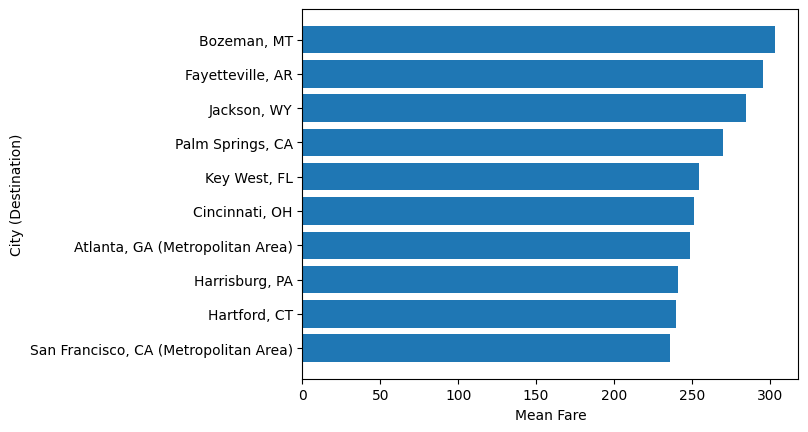

In [6]:
''' Chart 1: avg fare by dest. city '''
# Group, take avg. of fares by city. Sort by fare, asc. #
c1_df = faresByCity_df.groupby('city2')['fare'].mean()
c1_df_sorted = c1_df.sort_values().reset_index()

x = c1_df_sorted.tail(10)['city2']
y = c1_df_sorted.tail(10)['fare']

plt.barh(x,y)
plt.xlabel("Mean Fare")
plt.ylabel("City (Destination)")
plt.show()

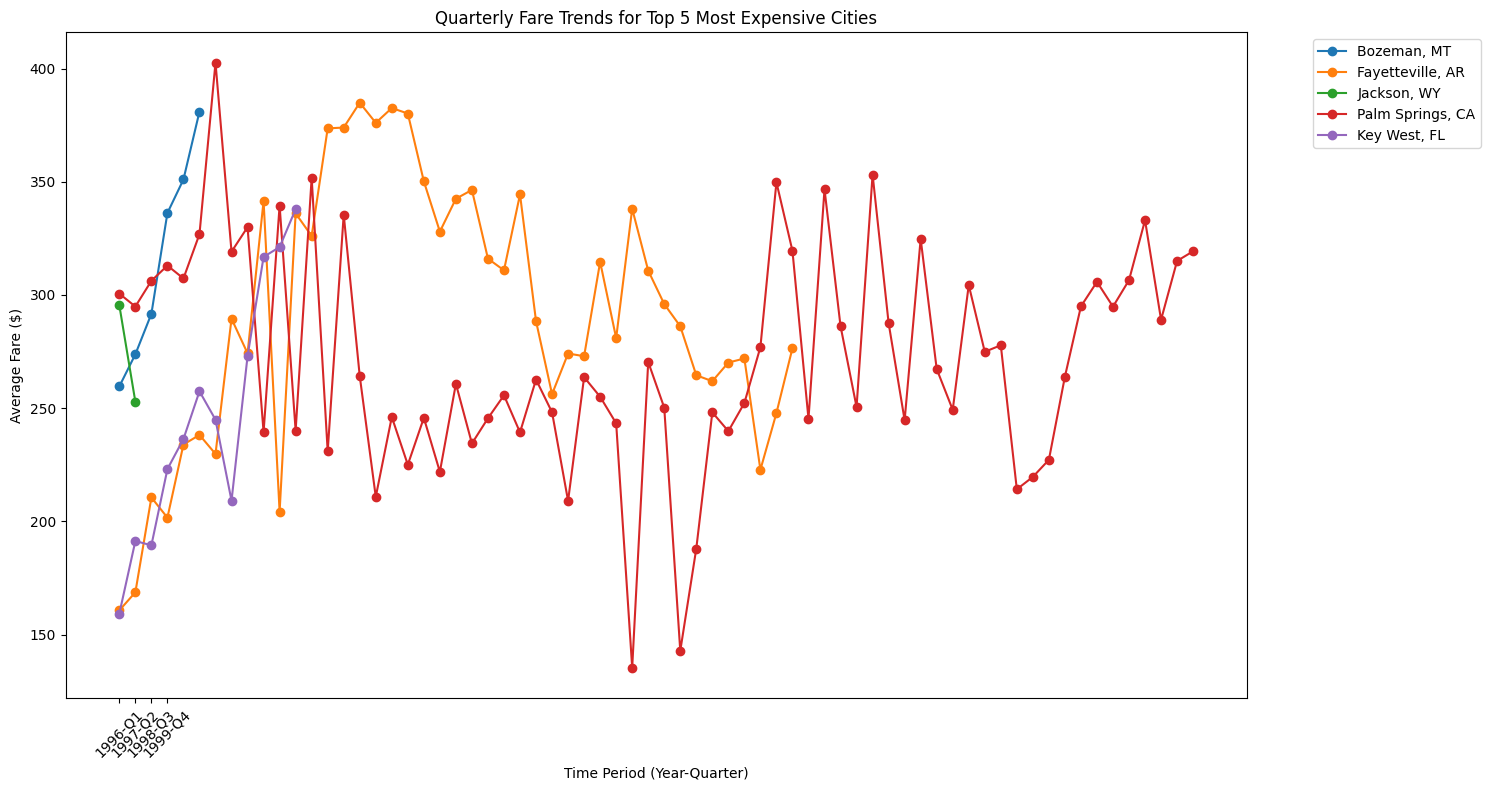

In [7]:
''' Chart 2: Avg. fare by city, by quarter'''
def plot_quarterly_city_fares(faresByCity_df, top_n=5):
    """Plot quarterly fare trends for top N cities by average fare"""
    # Get top N most expensive cities
    top_cities = faresByCity_df.groupby('city2')['fare'].mean().nlargest(top_n).index
    
    # Filter data for top cities
    top_cities_data = faresByCity_df[faresByCity_df['city2'].isin(top_cities)]
    
    # Calculate quarterly averages for each city
    quarterly_avg = top_cities_data.groupby(['Year', 'quarter', 'city2'])['fare'].mean().reset_index()
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    for city in top_cities:
        city_data = quarterly_avg[quarterly_avg['city2'] == city]
        plt.plot(range(len(city_data)), city_data['fare'], label=city, marker='o')
    
    plt.xlabel('Time Period (Year-Quarter)')
    plt.ylabel('Average Fare ($)')
    plt.title(f'Quarterly Fare Trends for Top {top_n} Most Expensive Cities')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create custom x-axis labels
    tick_labels = [f"{year}-Q{quarter}" for year, quarter 
                  in zip(quarterly_avg['Year'].unique(), quarterly_avg['quarter'].unique())]
    plt.xticks(range(len(tick_labels)), tick_labels, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
plot_quarterly_city_fares(faresByCity_df)

In [8]:
'''Chart 3: avg fair by carrier, by quarter'''

'Chart 3: avg fair by carrier, by quarter'

In [9]:
def extract_coordinates(geocoded_str):
    """Extract coordinates from the geocoded string"""
    if pd.isna(geocoded_str):
        return None
    try:
        coord_part = str(geocoded_str).split('\r\n')[1]
        match = re.search(r'\(([-\d.]+),\s*([-\d.]+)\)', coord_part)
        if match:
            return (float(match.group(1)), float(match.group(2)))
        return None
    except:
        return None

def calculate_distance(coord1, coord2):
    """Calculate distance between two coordinate pairs"""
    if coord1 is None or coord2 is None:
        return None
    return geodesic(coord1, coord2).miles

def get_city_coordinates(city, df, is_origin=True):
    """Get coordinates for a city from the dataframe"""
    column = 'Geocoded_City1' if is_origin else 'Geocoded_City2'
    city_data = df[df['city1' if is_origin else 'city2'] == city][column].iloc[0]
    return extract_coordinates(city_data)

def prepare_data(faresByCity_df, carriers_df):
    """Prepare data with carrier prices from both carriers"""
    expanded_rows = []
    
    for _, row in faresByCity_df.iterrows():
        # Add first carrier if fare exists
        if pd.notna(row['fare_lg']):
            expanded_rows.append({
                'city1': row['city1'],
                'city2': row['city2'],
                'nsmiles': row['nsmiles'],
                'quarter': row['quarter'],
                'passengers': row['passengers'],
                'carrier': row['carrier_lg'],
                'market_share': row['large_ms'],
                'fare': row['fare_lg'],
                'Geocoded_City1': row['Geocoded_City1'],
                'Geocoded_City2': row['Geocoded_City2']
            })
        
        # Add second carrier if fare exists
        if pd.notna(row['fare_low']):
            expanded_rows.append({
                'city1': row['city1'],
                'city2': row['city2'],
                'nsmiles': row['nsmiles'],
                'quarter': row['quarter'],
                'passengers': row['passengers'],
                'carrier': row['carrier_low'],
                'market_share': row['lf_ms'],
                'fare': row['fare_low'],
                'Geocoded_City1': row['Geocoded_City1'],
                'Geocoded_City2': row['Geocoded_City2']
            })
    
    # Create DataFrame with both carriers
    expanded_df = pd.DataFrame(expanded_rows)
    
    # Drop any remaining rows with NaN values
    expanded_df = expanded_df.dropna()
    
    # Extract coordinates once and store them
    print("Extracting coordinates...")
    expanded_df['origin_coords'] = expanded_df['Geocoded_City1'].apply(extract_coordinates)
    expanded_df['dest_coords'] = expanded_df['Geocoded_City2'].apply(extract_coordinates)
    
    # Drop rows where coordinate extraction failed
    expanded_df = expanded_df.dropna(subset=['origin_coords', 'dest_coords'])
    
    # Create encoders
    origin_encoder = LabelEncoder()
    dest_encoder = LabelEncoder()
    
    # Encode features
    expanded_df['origin_encoded'] = origin_encoder.fit_transform(expanded_df['city1'])
    expanded_df['dest_encoded'] = dest_encoder.fit_transform(expanded_df['city2'])
    carrier_dummies = pd.get_dummies(expanded_df['carrier'], prefix='carrier')
    
    # Create feature matrix
    X = pd.concat([
        pd.DataFrame({
            'distance': expanded_df['nsmiles'],
            'quarter': expanded_df['quarter'],
            'passengers': expanded_df['passengers'],
            'origin': expanded_df['origin_encoded'],
            'destination': expanded_df['dest_encoded'],
            'market_share': expanded_df['market_share']
        }),
        carrier_dummies
    ], axis=1)
    
    carrier_list = list(expanded_df['carrier'].unique())
    return X, expanded_df['fare'], origin_encoder, dest_encoder, carrier_list, expanded_df

In [10]:
def predict_route_fare(model, origin_city, dest_city, quarter, passengers, carrier,
                      origin_encoder, dest_encoder, carrier_list, 
                      faresByCity_df, carriers_df):
    """Predict fare for any city pair with specific carrier"""
    try:
        # Store the exact feature order from training data
        feature_order = ['distance', 'quarter', 'passengers', 'origin', 'destination', 'market_share',
                        'carrier_9N', 'carrier_A7', 'carrier_AA', 'carrier_AQ', 'carrier_AS', 
                        'carrier_B6', 'carrier_CO', 'carrier_DH', 'carrier_DL', 'carrier_E9', 
                        'carrier_EV', 'carrier_F9', 'carrier_FF', 'carrier_FL', 'carrier_G4', 
                        'carrier_HP', 'carrier_J7', 'carrier_JI', 'carrier_KP', 'carrier_KW', 
                        'carrier_L4', 'carrier_N5', 'carrier_N7', 'carrier_NJ', 'carrier_NK', 
                        'carrier_NW', 'carrier_OE', 'carrier_OO', 'carrier_P9', 'carrier_PN', 
                        'carrier_QQ', 'carrier_QX', 'carrier_RP', 'carrier_RU', 'carrier_SM', 
                        'carrier_SX', 'carrier_SY', 'carrier_T3', 'carrier_TB', 'carrier_TW', 
                        'carrier_TZ', 'carrier_U5', 'carrier_UA', 'carrier_US', 'carrier_VX', 
                        'carrier_W7', 'carrier_W9', 'carrier_WN', 'carrier_WV', 'carrier_XJ', 
                        'carrier_YV', 'carrier_YX', 'carrier_ZA', 'carrier_ZW']
        
        # Check if direct route exists
        direct_route = faresByCity_df[
            (faresByCity_df['city1'] == origin_city) & 
            (faresByCity_df['city2'] == dest_city)
        ]
        
        route_exists = len(direct_route) > 0
        if route_exists:
            distance = direct_route['nsmiles'].iloc[0]
            route_carriers = {
                direct_route['carrier_lg'].iloc[0], 
                direct_route['carrier_low'].iloc[0]
            }
            carrier_serves_route = carrier in route_carriers
            
            if carrier == direct_route['carrier_lg'].iloc[0]:
                market_share = direct_route['large_ms'].iloc[0]
            elif carrier == direct_route['carrier_low'].iloc[0]:
                market_share = direct_route['lf_ms'].iloc[0]
            else:
                market_share = 0.5
        else:
            origin_coords = get_city_coordinates(origin_city, faresByCity_df, is_origin=True)
            dest_coords = get_city_coordinates(dest_city, faresByCity_df, is_origin=False)
            distance = calculate_distance(origin_coords, dest_coords)
            carrier_serves_route = False
            market_share = 0.5
        
        # Encode cities
        origin_encoded = origin_encoder.transform([origin_city])[0]
        dest_encoded = dest_encoder.transform([dest_city])[0]
        
        # Initialize all features
        features_dict = {
            'distance': distance,
            'quarter': quarter,
            'passengers': passengers,
            'origin': origin_encoded,
            'destination': dest_encoded,
            'market_share': market_share
        }
        
        # Add all carrier features with 0s
        for feat in feature_order:
            if feat.startswith('carrier_'):
                features_dict[feat] = 1 if f'carrier_{carrier}' == feat else 0
        
        # Create DataFrame with single row and exact feature order
        X_pred = pd.DataFrame([features_dict])[feature_order]
        
        # Verify feature order matches
        if list(X_pred.columns) != feature_order:
            raise ValueError("Feature order mismatch")
        
        predicted_fare = model.predict(X_pred)[0]
        
        return {
            'predicted_fare': f"${predicted_fare:.2f}",
            'distance': f"{distance:.1f} miles",
            'origin': origin_city,
            'destination': dest_city,
            'carrier': carrier,
            'quarter': f"Q{quarter}",
            'passengers': passengers,
            'route_exists': route_exists,
            'carrier_serves_route': carrier_serves_route,
            'market_share': f"{market_share*100:.1f}%"
        }
        
    except Exception as e:
        print(f"Debug - Expected features: {feature_order}")
        print(f"Debug - Input features: {list(X_pred.columns)}")
        return f"Error making prediction: {str(e)}"

In [11]:
def get_fare_prediction(origin, destination, quarter, passengers, carrier):
    return predict_route_fare(
        model=model,
        origin_city=origin,
        dest_city=destination,
        quarter=quarter,
        passengers=passengers,
        carrier=carrier,
        origin_encoder=origin_encoder,
        dest_encoder=dest_encoder,
        carrier_list=carrier_list,
        faresByCity_df=faresByCity_df_original,
        carriers_df=carriers_df
    )

# Load and prepare data
print("Loading data...")
faresByCity_df_original = pd.read_csv("data/city_pair_fares.csv")
carriers_df = pd.read_csv("data/carriers_routes.csv")

print("Preparing data...")
X, y, origin_encoder, dest_encoder, carrier_list, model_df = prepare_data(faresByCity_df_original, carriers_df)

print("Training model...")
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
model.fit(X, y)

Loading data...
Preparing data...
Extracting coordinates...
Training model...


RandomForestRegressor(max_depth=15, min_samples_split=5, n_jobs=-1,
                      random_state=42)

In [12]:
# Test prediction
test_pred = predict_route_fare(
    model=model,
    origin_city="Denver, CO",
    dest_city="Seattle, WA",
    quarter=4,
    passengers=500,
    carrier="DL",
    origin_encoder=origin_encoder,
    dest_encoder=dest_encoder,
    carrier_list=carrier_list,
    faresByCity_df=faresByCity_df_original,
    carriers_df=carriers_df
)
print("\nTest prediction:")
print(test_pred)


Test prediction:
{'predicted_fare': '$184.74', 'distance': '1024.0 miles', 'origin': 'Denver, CO', 'destination': 'Seattle, WA', 'carrier': 'DL', 'quarter': 'Q4', 'passengers': 500, 'route_exists': True, 'carrier_serves_route': False, 'market_share': '50.0%'}


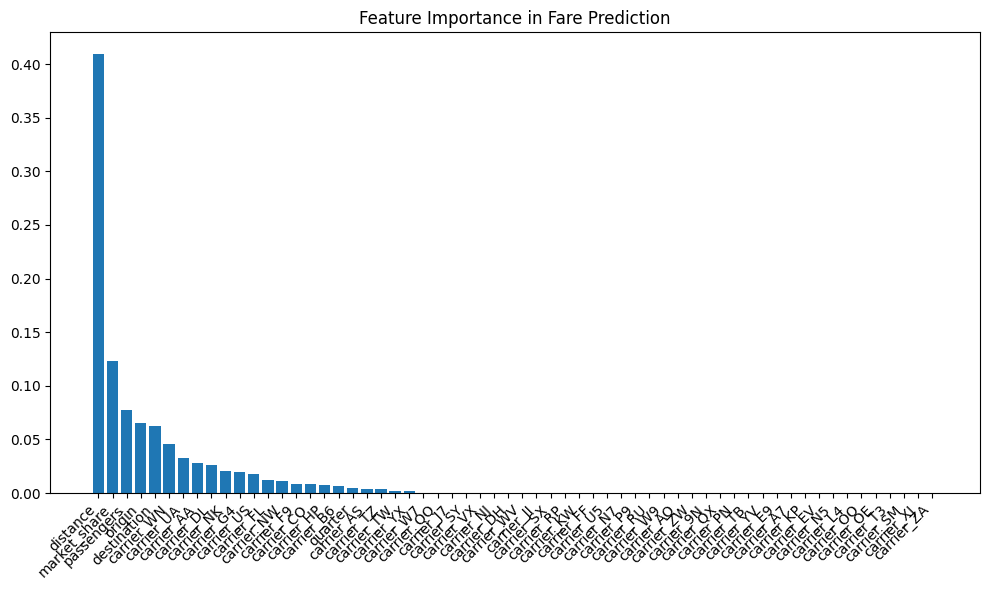

In [13]:
# Plot feature importance
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importances['feature'], importances['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance in Fare Prediction')
plt.tight_layout()
plt.show()

Training neural network model...
Iteration 1, loss = 3024.10171554
Validation score: 0.440352
Iteration 2, loss = 1110.12231031
Validation score: 0.507606
Iteration 3, loss = 1058.24993747
Validation score: 0.518264
Iteration 4, loss = 1038.94542356
Validation score: 0.525209
Iteration 5, loss = 1027.21379786
Validation score: 0.532084
Iteration 6, loss = 1017.97948311
Validation score: 0.533684
Iteration 7, loss = 1009.76373395
Validation score: 0.537197
Iteration 8, loss = 1002.21821444
Validation score: 0.534417
Iteration 9, loss = 993.52750080
Validation score: 0.543410
Iteration 10, loss = 988.83887530
Validation score: 0.544907
Iteration 11, loss = 982.52630546
Validation score: 0.546319
Iteration 12, loss = 975.19212913
Validation score: 0.537872
Iteration 13, loss = 968.68656156
Validation score: 0.554315
Iteration 14, loss = 964.21845022
Validation score: 0.552074
Iteration 15, loss = 956.12979006
Validation score: 0.558528
Iteration 16, loss = 950.93368661
Validation score: 0

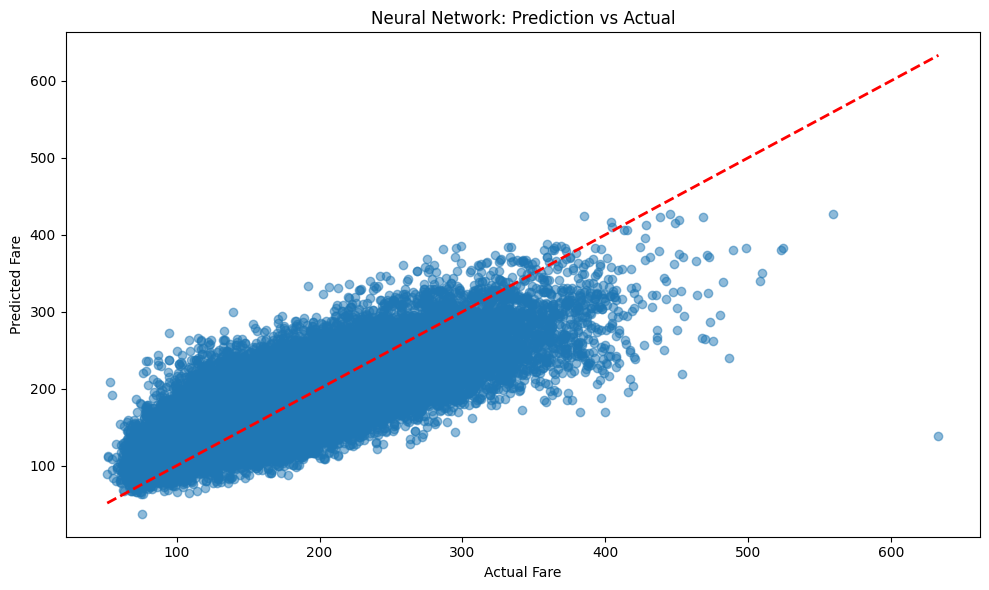

In [24]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

def train_neural_network(X, y):
    """Train and evaluate a neural network model"""
    # Define feature order
    feature_order = ['distance', 'quarter', 'passengers', 'origin', 'destination', 'market_share',
                    'carrier_9N', 'carrier_A7', 'carrier_AA', 'carrier_AQ', 'carrier_AS', 
                    'carrier_B6', 'carrier_CO', 'carrier_DH', 'carrier_DL', 'carrier_E9', 
                    'carrier_EV', 'carrier_F9', 'carrier_FF', 'carrier_FL', 'carrier_G4', 
                    'carrier_HP', 'carrier_J7', 'carrier_JI', 'carrier_KP', 'carrier_KW', 
                    'carrier_L4', 'carrier_N5', 'carrier_N7', 'carrier_NJ', 'carrier_NK', 
                    'carrier_NW', 'carrier_OE', 'carrier_OO', 'carrier_P9', 'carrier_PN', 
                    'carrier_QQ', 'carrier_QX', 'carrier_RP', 'carrier_RU', 'carrier_SM', 
                    'carrier_SX', 'carrier_SY', 'carrier_T3', 'carrier_TB', 'carrier_TW', 
                    'carrier_TZ', 'carrier_U5', 'carrier_UA', 'carrier_US', 'carrier_VX', 
                    'carrier_W7', 'carrier_W9', 'carrier_WN', 'carrier_WV', 'carrier_XJ', 
                    'carrier_YV', 'carrier_YX', 'carrier_ZA', 'carrier_ZW']
    
    # Ensure X has correct column order
    X = X[feature_order]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # Create and train the model
    nn_model = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2,
        verbose=True
    )
    
    nn_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = nn_model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nNeural Network Metrics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2)
    plt.xlabel('Actual Fare')
    plt.ylabel('Predicted Fare')
    plt.title('Neural Network: Prediction vs Actual')
    plt.tight_layout()
    plt.show()
    
    return nn_model, scaler, feature_order

def predict_route_fare_nn(nn_model, scaler, origin_city, dest_city, quarter, 
                         passengers, carrier, origin_encoder, dest_encoder, 
                         carrier_list, faresByCity_df, carriers_df, feature_order):
    """Predict fare using the neural network model independently"""
    try:
        # Check if direct route exists
        direct_route = faresByCity_df[
            (faresByCity_df['city1'] == origin_city) & 
            (faresByCity_df['city2'] == dest_city)
        ]
        
        route_exists = len(direct_route) > 0
        if route_exists:
            distance = direct_route['nsmiles'].iloc[0]
            route_carriers = {
                direct_route['carrier_lg'].iloc[0], 
                direct_route['carrier_low'].iloc[0]
            }
            carrier_serves_route = carrier in route_carriers
            
            if carrier == direct_route['carrier_lg'].iloc[0]:
                market_share = direct_route['large_ms'].iloc[0]
            elif carrier == direct_route['carrier_low'].iloc[0]:
                market_share = direct_route['lf_ms'].iloc[0]
            else:
                market_share = 0.5
        else:
            origin_coords = get_city_coordinates(origin_city, faresByCity_df, is_origin=True)
            dest_coords = get_city_coordinates(dest_city, faresByCity_df, is_origin=False)
            distance = calculate_distance(origin_coords, dest_coords)
            carrier_serves_route = False
            market_share = 0.5
            
        # Initialize features dictionary
        features_dict = {
            'distance': distance,
            'quarter': quarter,
            'passengers': passengers,
            'origin': origin_encoder.transform([origin_city])[0],
            'destination': dest_encoder.transform([dest_city])[0],
            'market_share': market_share
        }
        
        # Add carrier features in the correct order
        for feat in feature_order:
            if feat.startswith('carrier_'):
                features_dict[feat] = 1 if f'carrier_{carrier}' == feat else 0
        
        # Create DataFrame with exact feature order
        X_pred = pd.DataFrame([features_dict])[feature_order]
        
        # Scale features
        X_pred_scaled = scaler.transform(X_pred)
        
        # Make prediction
        predicted_fare = nn_model.predict(X_pred_scaled)[0]
        
        return {
            'predicted_fare': f"${predicted_fare:.2f}",
            'distance': f"{distance:.1f} miles",
            'origin': origin_city,
            'destination': dest_city,
            'carrier': carrier,
            'quarter': f"Q{quarter}",
            'passengers': passengers,
            'route_exists': route_exists,
            'carrier_serves_route': carrier_serves_route,
            'market_share': f"{market_share*100:.1f}%"
        }
        
    except Exception as e:
        print(f"Debug - Expected features: {feature_order}")
        print(f"Debug - Input features: {list(X_pred.columns) if 'X_pred' in locals() else 'Not created'}")
        return f"Error making prediction: {str(e)}"

# Train the model
print("Training neural network model...")
nn_model, feature_scaler, feature_order = train_neural_network(X, y)

In [25]:
# Test the prediction
test_pred_nn = predict_route_fare_nn(
    nn_model=nn_model,
    scaler=feature_scaler,
    origin_city="Denver, CO",
    dest_city="Seattle, WA",
    quarter=4,
    passengers=500,
    carrier="DL",
    origin_encoder=origin_encoder,
    dest_encoder=dest_encoder,
    carrier_list=carrier_list,
    faresByCity_df=faresByCity_df_original,
    carriers_df=carriers_df,
    feature_order=feature_order  # Pass the feature order
)

print(test_pred_nn)

{'predicted_fare': '$182.20', 'distance': '1024.0 miles', 'origin': 'Denver, CO', 'destination': 'Seattle, WA', 'carrier': 'DL', 'quarter': 'Q4', 'passengers': 500, 'route_exists': True, 'carrier_serves_route': False, 'market_share': '50.0%'}
